##  Transfer Learning Using Self-supervised Pretraining

- Flowers dataset https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamidrezahazaveh","key":"ffcaf69325684c112d615e2bafbc2e4f"}'}

In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [3]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip flowers-recognition.zip -d flowers

Archive:  flowers-recognition.zip
replace flowers/flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: flowers/flowers/daisy/100080576_f52e8ee070_n.jpg  
replace flowers/flowers/daisy/10140303196_b88d3d6cec.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: flowers/flowers/daisy/10140303196_b88d3d6cec.jpg  
replace flowers/flowers/daisy/10172379554_b296050f82_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: flowers/flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/fl

In [5]:
import os
os.listdir('flowers')

['flowers']

In [6]:
!pip install -q lightning-bolts

In [7]:
! pip install -q torchmetrics

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import pl_bolts
import torchvision
import torchmetrics
import pytorch_lightning as pl

from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

from torchvision import models
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger

/usr/local/lib/python3.11/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.11/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.11/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.11/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The featu

Point the data_dir to where your flowers dataset is loaded in Google Drive

Original images are not square and all of different sizes

In [9]:
data_dir = 'flowers'

os.listdir(data_dir)

['flowers']

First of all images need to be of same size (resized to 224 x 224) and to be converted to Tensor form and normalized.

- Pre-trained models in Pytorch expect images to be at least 224 x 224 in size
- Images are also normalized using the mean and standard deviation of the Imagenet dataset which comprises of millions of images
- If you know the mean and standard deviation of your own image dataset you can use that to normalize images

Data module inherited from LightningDataModule:

A collection of a train_dataloaders, val_dataloaders, test_dataloaders along with the matching transforms and data processing/downloads steps required.

To define a DataModule define 5 methods:

1.prepare_data (how to download(), tokenize, etc…) (not implemented in this case)

2.setup (how to split, etc…)

3.train_dataloader

4.val_dataloader(s)

5.test_dataloader(s) (Not implemented in this case)

Agument the data to increase the number of samples used to fine-tune the pre-trained model on our data

Link for reference:

https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html#what-is-a-datamodule

In [10]:
class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, data_dir =  'flowers'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose(
          [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.1),
            transforms.RandomRotation(10),
              transforms.ToTensor(),
              transforms.Normalize(
                  mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
              ),
          ]
        )

    def setup(self, stage= None):
        flower_full = ImageFolder(self.data_dir, transform = self.transform)

        length = len(flower_full)

        val_split_size = 0.2

        train_length = round(length * (1 - val_split_size))
        val_length = length - train_length

        self.flower_train, self.flower_val = \
          random_split(flower_full , [train_length, val_length])

    def train_dataloader(self):
        train_dataloader = \
          DataLoader(self.flower_train, batch_size = 32, shuffle = True)

        return train_dataloader

    def val_dataloader(self):
        val_dataloader = \
          DataLoader(self.flower_val, batch_size = 32)

        return val_dataloader


Flower Data module is instantiated and setup is called

In [11]:
flower_dm = FlowerDataModule()

flower_dm.setup()

Training and validation dataloaders are obtained and dimensions are checked. Note that len(dataloader) gives no. of batches as Dataloader loads images in batch form.

In [12]:
train_dl = flower_dm.train_dataloader()

len(train_dl)

108

In [13]:
valid_dl = flower_dm.val_dataloader()

len(valid_dl)

27

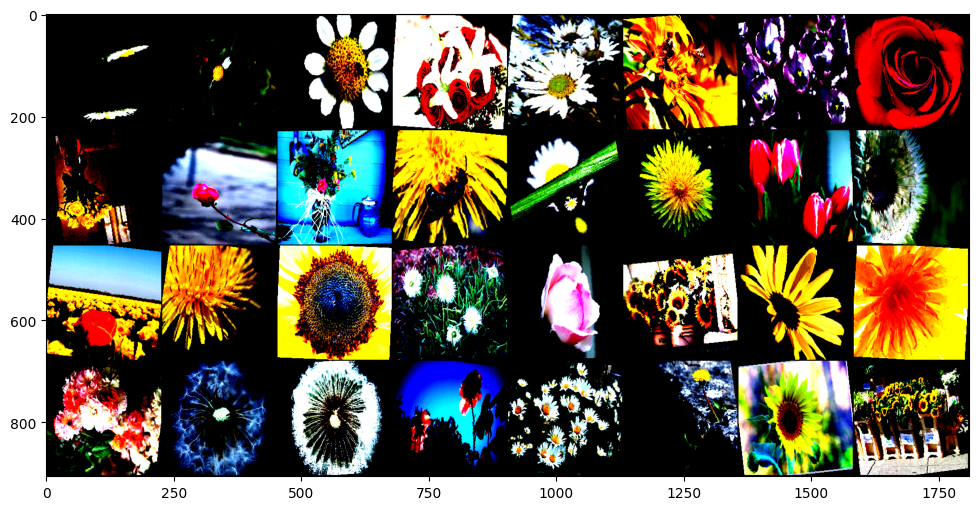

In [14]:
def show_batch_images(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

show_batch_images(train_dl)

## Self-Supervised Pretraining with SIMCLR
https://pytorch-lightning-bolts.readthedocs.io/en/latest/self_supervised_models.html#simclr

We use pretrained SimCLR model trained on imagenet data (self-supervised)

Note that here we are unfreezing our backbone after 10 epochs of training of model.

In [15]:
from pl_bolts.models.self_supervised import SimCLR

class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'

        simclr = SimCLR.load_from_checkpoint(weight_path, strict = False)

        self.backbone = simclr
        self.finetune_layer = torch.nn.Linear(2048, num_classes)

    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.trainer.current_epoch < 10:
            with torch.no_grad():
                features = self.backbone(x)
        else:
            features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.num_classes)

        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return loss

    def validation_step(self, batch, batch_idx):

        x, y = batch

        features = self.backbone(x)

        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score =  accuracy(preds, y, task='multiclass', num_classes=self.num_classes)

        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True, logger = True)

        return metrics

    def configure_optimizers(self):

        optimizer = Adam(self.parameters(), lr = self.hparams.lr)

        return optimizer

CSV Logger is defined to log the metrics into a csv file

In [16]:
logger = CSVLogger(save_dir = './lightning_logs', name = 'simclr_bb_unfrozen')

Classifier is called and Trainer is defined and fit with Flower Datamodule. Training is done for 20 epochs and logger is used for logging metrics

In [17]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(gpus = 1, max_epochs = 20, logger = logger)

trainer.fit(classifier, flower_dm)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt`
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/saving.py:234: UnderReviewWarning: The feature SimCLR is currently marked under review. The compatibility with other Lig

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [18]:
# classifier = FlowerImageClassifier()

# trainer = pl.Trainer(max_epochs = 20,
#                      limit_train_batches = 20,
#                      log_every_n_steps = 10, logger = logger, gpus = 1)

# trainer.fit(classifier, flower_dm)

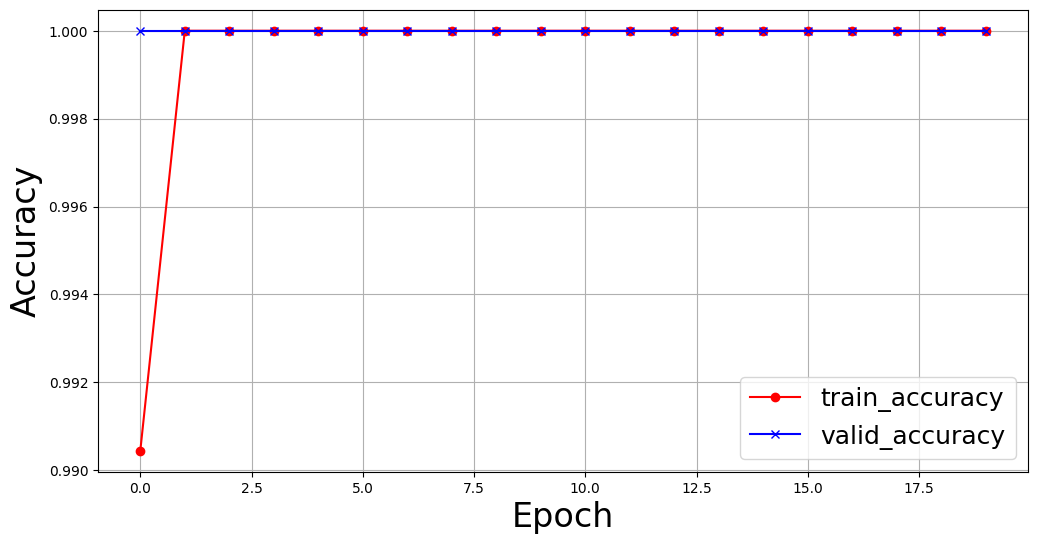

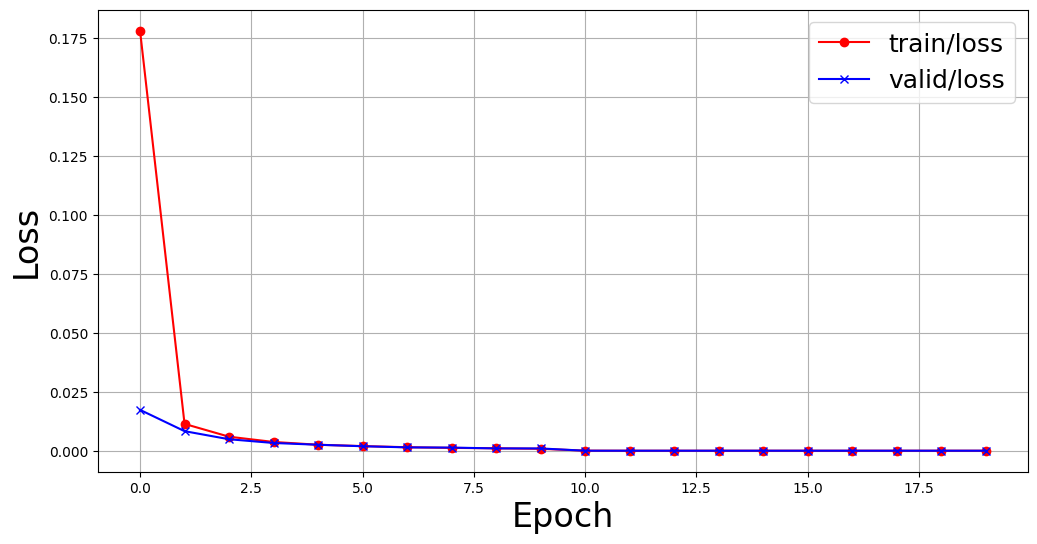

In [19]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
train_acc = metrics['train_acc'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)
valid_acc = metrics['valid_acc'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'valid_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_ssl_simclr.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop = True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop = True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_loss, color = 'r', marker = 'o', label = 'train/loss')
plt.plot(valid_loss, color = 'b', marker = 'x', label = 'valid/loss')

plt.ylabel('Loss', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'upper right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/loss_ssl_simclr.png')

In [20]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metrics

,valid_loss,valid_acc,epoch,step,train_loss,train_acc
0,1.732341e-02,1.0,0,107,NaN,NaN
1,NaN,NaN,0,107,1.780619e-01,0.990446
2,8.290567e-03,1.0,1,215,NaN,NaN
3,NaN,NaN,1,215,1.137156e-02,1.000000
4,4.866609e-03,1.0,2,323,NaN,NaN
5,NaN,NaN,2,323,5.943430e-03,1.000000
6,3.284500e-03,1.0,3,431,NaN,NaN
7,NaN,NaN,3,431,3.712691e-03,1.000000
8,2.528075e-03,1.0,4,539,NaN,NaN
9,NaN,NaN,4,539,2.534556e-03,1.000000


![](img/20201117-1-train_acc.svg "Train Accuracy")

![](img/20201117-1-train_loss.svg "Train Loss")